### Import libraries

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report

### Import data

In [2]:
with open(r'config.yml') as file:
    val = yaml.load(file, Loader=yaml.FullLoader)

In [3]:
data = pd.read_csv("BankChurners_Trans.csv")

### Feature Selection

#### Highly Correlated variables

In [4]:
numerical_data = data[val['numerical_variables']]

In [5]:
columns = numerical_data.columns
correlation = numerical_data.corr().values
for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        if abs(correlation[i, j]) >= 0.7:
            print(columns[i], columns[j], correlation[i, j])

Customer_Age Months_on_book 0.7889123589930555
Credit_Limit Avg_Open_To_Buy 0.9959805439320076
Total_Trans_Amt Total_Trans_Ct 0.8071920346514353


In [6]:
correlated_variables = ["Months_on_book", "Avg_Open_To_Buy", "Total_Trans_Ct"]

In [7]:
data_1 = data.drop(correlated_variables, axis=1)

In [8]:
x_data = data_1.drop("Attrition_Flag", axis=1)
y_data = data_1["Attrition_Flag"]

In [9]:
columnas = data_1.drop("Attrition_Flag", axis=1).columns

#### Logistic Regression

In [10]:
x_data_cop = x_data.copy()
columnas_no_significativas = []
while True:
    log_reg = sm.Logit(y_data, sm.add_constant(x_data_cop)).fit()
    p_valores = log_reg.pvalues
    max_p_valores = p_valores.max()
    max_indice = p_valores.argmax()
    max_columna = p_valores.index[max_indice]
    if max_p_valores > 0.05:
        print(f"Columna Eliminada: {max_columna}, P-Valor: {max_p_valores}")
        columnas_no_significativas.append(max_columna)
        x_data_cop.drop([max_columna], axis=1, inplace=True)
        print('--'*15)
    else:
        break

Optimization terminated successfully.
         Current function value: 0.306244
         Iterations 7
Columna Eliminada: Customer_Age, P-Valor: 0.927989287621355
------------------------------


/Users/juanhernandez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/juanhernandez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.306244
         Iterations 7
Columna Eliminada: Total_Amt_Chng_Q4_Q1, P-Valor: 0.8422147818101591
------------------------------
Optimization terminated successfully.
         Current function value: 0.306246
         Iterations 7
Columna Eliminada: Education_Level, P-Valor: 0.7250876719296852
------------------------------
Optimization terminated successfully.
         Current function value: 0.306252
         Iterations 7
Columna Eliminada: Single, P-Valor: 0.62624496699853
------------------------------
Optimization terminated successfully.
         Current function value: 0.306264
         Iterations 7
Columna Eliminada: Unknown, P-Valor: 0.33791250044558974
------------------------------
Optimization terminated successfully.
         Current function value: 0.306309
         Iterations 7


/Users/juanhernandez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/juanhernandez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/juanhernandez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/juanhernandez/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [11]:
columnas_no_significativas

['Customer_Age',
 'Total_Amt_Chng_Q4_Q1',
 'Education_Level',
 'Single',
 'Unknown']

In [12]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:         Attrition_Flag   No. Observations:                10127
Model:                          Logit   Df Residuals:                    10113
Method:                           MLE   Df Model:                           13
Date:                Sat, 10 Dec 2022   Pseudo R-squ.:                  0.3050
Time:                        12:24:33   Log-Likelihood:                -3102.0
converged:                       True   LL-Null:                       -4463.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.4388      0.045    -54.420      0.000      -2.527      -2.351
Gender                       0.2753      0.055      5.005      0.000       0.167       0.

#### Lasso Regression

In [13]:
model = LogisticRegression(penalty="l1", solver="liblinear")
skf = StratifiedKFold(n_splits=15, shuffle=True)
results = []
for train_index, test_index in skf.split(x_data, y_data):
    X_train, X_test = x_data.loc[train_index], x_data.loc[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1 = f1_score(y_test, pred)
    results.append(f1)

In [14]:
print(f'Average F1-Score: {round(np.mean(results), 2)}')

Average F1-Score: 0.55


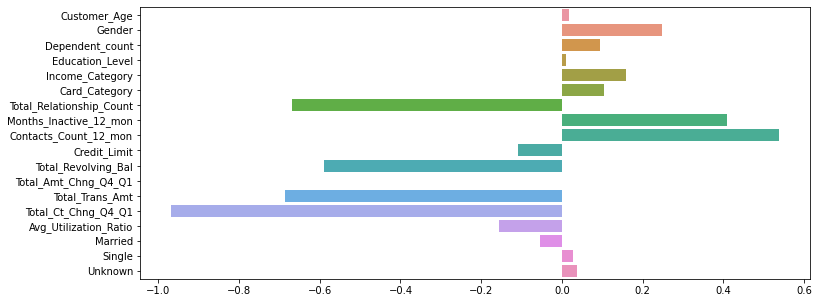

In [15]:
plt.figure(figsize=(12, 5))
sns.barplot(y=x_data.columns, x=model.coef_[0]);

#### Trees

In [16]:
model = RandomForestClassifier(n_estimators=150)
skf = StratifiedKFold(n_splits=15, shuffle=True)
results = []
for train_index, test_index in skf.split(x_data, y_data):
    X_train, X_test = x_data.loc[train_index], x_data.loc[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1 = f1_score(y_test, pred)
    results.append(f1)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       566
           1       0.93      0.69      0.79       109

    accuracy                           0.94       675
   macro avg       0.93      0.84      0.88       675
weighted avg       0.94      0.94      0.94       675



In [17]:
print(f'Average F1-Score: {round(np.mean(results), 2)}')

Average F1-Score: 0.83


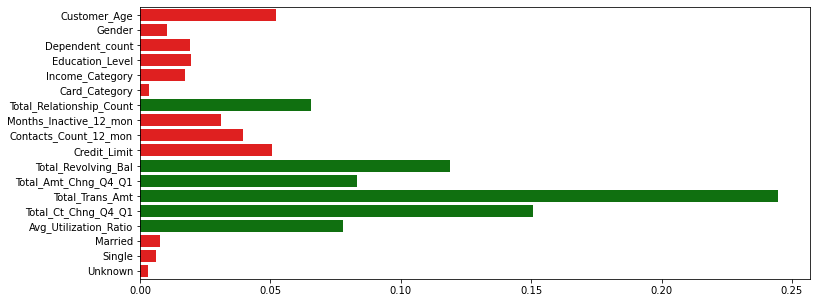

In [18]:
mean_feature_importance = model.feature_importances_.mean()
palette = ['green' if val > mean_feature_importance else 'red' for val in model.feature_importances_]
plt.figure(figsize=(12, 5))
sns.barplot(y=x_data.columns, x=model.feature_importances_, palette=palette);